In [1]:
import pandas as pd                                     
import numpy as np                                     
import os                                              
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
%matplotlib inline

# 1. Data exploration & cleaning

In this section we will clean the data to output a dataset on which we can learn our models.

In [4]:
# Import data
data = pd.read_csv(os.path.join('CrowdstormingDataJuly1st.csv'))
indexed_data=data.set_index(keys=['player','refNum'])
indexed_data.ix[:2,:13]

,,playerShort,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
player,refNum,,,,,,,,,,,,,
Lucas Wilchez,1,lucas-wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
John Utaka,2,john-utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1


In [5]:
indexed_data.ix[:2,13:]

,,yellowReds,redCards,photoID,rater1,rater2,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
player,refNum,,,,,,,,,,,,,
Lucas Wilchez,1,0,0,95212.jpg,0.25,0.50,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
John Utaka,2,0,0,1663.jpg,0.75,0.75,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504


In [6]:
# Make sure that we have only one entry per player-referee dyad
indexed_data.index.is_unique

False

There is not a single player-referee dyad. This is the first problem we need to fix. Let's figure out what is going on:

In [7]:
# Compute the player-refree indexes present in the table more than once
test_duplicate= data.groupby(by=['player','refNum']).count()
duplicate=test_duplicate.loc[test_duplicate['club']>1]
indexed_data.loc[duplicate.index].head(2)

playerShort                 club leagueCountry  \
player        refNum                                                      
 André Santos 88        andre-santos           Arsenal FC       England   
              88      andre-santos_2  Deportivo La Coruña         Spain   

                        birthday  height  weight           position  games  \
player        refNum                                                         
 André Santos 88      08.03.1983   180.0    74.0      Left Fullback      1   
              88      02.03.1989   178.0    72.0  Center Midfielder      1   

                      victories  ties    ...     rater1  rater2  refCountry  \
player        refNum                     ...                                  
 André Santos 88              0     0    ...       0.50    0.50           3   
              88              0     1    ...       0.25    0.25           3   

                      Alpha_3   meanIAT    nIAT     seIAT   meanExp    nExp  \
player        refNum                                                          
 André Santos 88          ESP  0.369894  1785.0  0.000229  0.588297  1897.0   
              88          ESP  0.369894  1785.0  0.000229  0.588297  1897.0   

                         seExp  
player        refNum            
 André Santos 88      0.001002  
              88      0.001002  

[2 rows x 26 columns]

Now we can see that the origin of the problem is that some players that are transfered from a club to another may have multiple entries for the same referee (one entry per club). So we will merge these entries into one single entry so that we have a single entry per player-ref. As the features related to the referee and its country as well as player information will be the same across duplicated entries we will save just one copy (using agg function 'first'). However, the features related to the rating may differ. One possible solution is to take the most commun value across the different entries for rater 1 as well as for rater 2.
Obviously, features like card number, games, defeats... must be summed (using agg function 'sum') 

In [8]:
total_number_dyads= len(indexed_data.index.unique())
print("We need to have a table with "+str(total_number_dyads)+" different player-ref entries.")

We need to have a table with 145712 different player-ref entries.


In [9]:
# set of all different indexes
all_indexes=set(indexed_data.index.unique())
# set of all indexes that have duplicated entries
duplicate_indexes=set(duplicate.index.unique())
# compute all indexes that have a single entry in the original table
single_entry_indexes= all_indexes.difference(duplicate_indexes)
# Extract the rows of the original data with only one entry per player-ref
good_data=indexed_data.loc[list(single_entry_indexes)]

In [10]:
# Group the duplicated indexes in the way described above
grouped_data=indexed_data.loc[duplicate.index]
grouped_data=grouped_data.reset_index().groupby(by=['player','refNum'])
aggregation_function={
     'playerShort': 'first',
     'club': 'first',
     'leagueCountry': 'first',
     'birthday':'first',
     'height': np.mean,
     'weight':np.mean,
     'position':'first',
     'games': np.sum,
     'victories':np.sum,
     'ties': np.sum,
     'defeats': np.sum,
     'goals': np.sum,
     'yellowCards':np.sum,
     'yellowReds': np.sum,
     'redCards':np.sum,
     'photoID': 'first',
     'rater1': lambda x:x.value_counts().index[0], #the most commun value across the different entries for rater 1 
     'rater2': lambda x:x.value_counts().index[0], #as well as for rater 2.
     'refCountry':'first',
     'Alpha_3':'first',
     'meanIAT': 'first',
     'nIAT':'first',
     'seIAT': 'first',
     'meanExp':'first',
     'nExp':'first',
     'seExp':'first'
}
grouped_data=grouped_data.agg(aggregation_function)
grouped_data.head(2)

defeats  weight    photoID  yellowReds    nExp  \
player        refNum                                                   
 André Santos 88            1    73.0  52851.jpg           0  1897.0   
              408           3    73.0  52851.jpg           0  1121.0   

                           position leagueCountry    birthday  goals  rater2  \
player        refNum                                                           
 André Santos 88      Left Fullback       England  08.03.1983      0    0.25   
              408     Left Fullback       England  08.03.1983      2    0.25   

                      ...    meanExp  height   meanIAT     seIAT    nIAT  \
player        refNum  ...                                                  
 André Santos 88      ...   0.588297   179.0  0.369894  0.000229  1785.0   
              408     ...   0.790366   179.0  0.396803  0.000392  1079.0   

                      Alpha_3   playerShort  rater1  refCountry  ties  
player        refNum                                                   
 André Santos 88          ESP  andre-santos    0.25           3     1  
              408         PRT  andre-santos    0.25          72     2  

[2 rows x 26 columns]

In [11]:
# Now we can merge the two dataframes to obtain the final complete dataset with unique player-ref
# entry
dupFree_data=pd.concat([good_data,grouped_data],axis=0)
print("We recovered "
    +str(len(dupFree_data)*100/total_number_dyads)
    + "% of the original data." )
if(good_data.index.is_unique): 
    print ("The new dataset doesn't contain duplicated dyads.")

We recovered 100.0% of the original data.
The new dataset doesn't contain duplicated dyads.


Now that the first problem is fixed, let's discover the distrubutionof the number of games that each refrees managed. Recall that after the modification we did earlier, the feature (column) 'games' represents the total number of games involving the corresponding dyad (player-ref). Hence, summing all 'games'(over all players) that involve a given refery will produce the number of matchs that this refery managed (multiplied by 22 since a match involve 22 players)

In [12]:
# Group the dataset by refrees to get the sum of the number of games (which devided by 22 
#gives an approximation to the number of matchs per referee)
games_per_ref=dupFree_data.reset_index().groupby(['refNum']).sum()[['games']]
games_per_ref['games']=games_per_ref['games']/22
# the total number of referees
num_refs = len(data.refNum.unique())

print ("Total number of referees =", num_refs)
games_per_ref.sort_values(by=['games']).head()

Total number of referees = 3147


,games
refNum,
1,0.045455
2886,0.045455
1164,0.045455
1174,0.045455
1186,0.045455


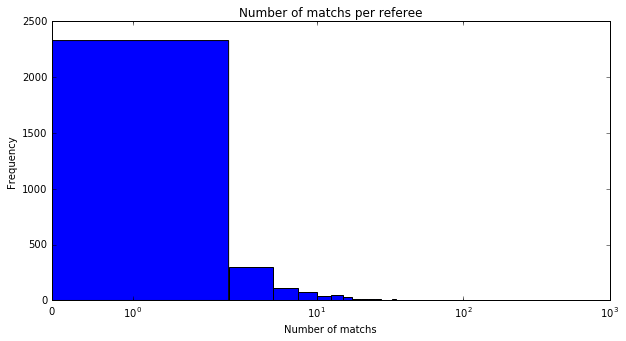

In [13]:
# Let's plot the number of games per ref
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
axes.hist(list(games_per_ref['games']),bins = 200, range = (0,500))
axes.set_xscale('symlog')  
axes.set_title("Number of matchs per referee")
axes.set_xlabel('Number of matchs')
axes.set_ylabel('Frequency')

The weard thing about this plot is that most of the referees managed one or less match during their carreer. The set of such referee should be deleted from the dataset.

In [14]:
good_refs=games_per_ref.loc[games_per_ref['games']>=1]
good_refs.head()

,games
refNum,
4,1.545455
7,21.272727
15,1.000000
16,2.318182
19,2.181818


In [15]:
goodData=pd.merge(good_refs.reset_index().drop('games',axis=1),dupFree_data.reset_index(),how='inner',left_on='refNum',right_on='refNum')
goodData=goodData.set_index(['player','refNum'])
print("We will follow our study with only "
      +str(round(len(good_refs)*100/num_refs,3))
      +"% of the referees.\n"
      +"Which corresponds to "
      +str(round(len(goodData)*100/len(dupFree_data),3))
      +"% of the total number of dyads.\n")
goodData.head(2)

We will follow our study with only 40.07% of the referees.
Which corresponds to 94.24% of the total number of dyads.



,,Alpha_3,birthday,club,defeats,games,goals,height,leagueCountry,meanExp,meanIAT,...,rater2,redCards,refCountry,seExp,seIAT,ties,victories,weight,yellowCards,yellowReds
player,refNum,,,,,,,,,,,,,,,,,,,,,
Nemanja Vidić,4,LUX,21.10.1981,Manchester United,0,2,0,188.0,England,0.538462,0.325185,...,0.00,0,4,0.013752,0.003297,0,2,82.0,0,0
Ivan Obradović,4,LUX,25.07.1988,Real Zaragoza,0,1,0,181.0,Spain,0.538462,0.325185,...,0.25,0,4,0.013752,0.003297,0,1,74.0,1,0


# 2. Supervised classification

## 1. Data pre-processing  

In this section we will use a random forest classifier that given a soccer player description outputs his skin color. First keep only the data related to the player and not the refree because this is the part of data we will use to predict the skin color. Hence we will group our "goodData" by player and use an appropriate aggregation function to extract useful infotmation for our model training.

In [16]:
aggregation_function_2={
     'club': 'first',
     'leagueCountry': 'first',
     'birthday':'first',
     'height': np.mean,
     'weight':np.mean,
     'position':'first',
     'games': np.sum,
     'victories':np.sum,
     'ties': np.sum,
     'defeats': np.sum,
     'goals': np.sum,
     'yellowCards':np.sum,
     'yellowReds': np.sum,
     'redCards':np.sum,
     'rater1': lambda x:x.value_counts().index[0], #the most commun value across the different entries for rater 1 
     'rater2': lambda x:x.value_counts().index[0], #as well as for rater 2.
}

In [17]:
# Drop features not related to the player
skinGoodData=goodData.reset_index().drop(['refNum',     # Related to the referee
                                          'playerShort',# Duplicated data 
                                          'photoID',    # Noise
                                          'refCountry', # Related to referee country
                                          'nIAT',       # Related to referee country
                                          'seIAT',      # Related to referee country
                                          'meanExp',    # Related to referee country
                                          'nExp',       # Related to referee country
                                          'seExp',      # Related to referee country
                                          'Alpha_3'     # Related to the player but we noticed a lot of
                                                        #incorrect information. Moreover, in some case, multiple 
                                                        #Alpha_3 values are related to the same player.             
                                         ], axis=1)

# Drop all raws where we both rater1 and rater2 are Nan
skinGoodData=skinGoodData.dropna(axis=0,how='all',subset=['rater1','rater2'])
# Group by player using the agg function we built
skinGoodData=skinGoodData.sort_values(by='player').groupby('player').agg(aggregation_function_2)
skinGoodData.head(2)

,defeats,games,weight,club,redCards,yellowReds,height,birthday,leagueCountry,rater1,position,goals,ties,yellowCards,rater2,victories
player,,,,,,,,,,,,,,,,
Adriano,84,369,67.0,FC Barcelona,3,1,172.0,26.10.1984,Spain,0.25,Left Midfielder,32,59,57,0.25,226
Adrián,87,294,73.0,Atlético Madrid,0,0,183.0,08.01.1988,Spain,0.25,Center Forward,60,62,16,0.00,145


In [18]:
# The number of raws where the rater1 and rater2 desagree
totalPlayerNum= len(skinGoodData)
desagreeNum=len(skinGoodData[skinGoodData['rater1']-skinGoodData['rater2']>0])
print("The number of players where the two raters desagree is "
      + str(desagreeNum)
      + " that corresponds to "
      + str(round(desagreeNum*100/totalPlayerNum,3))
      + "% of the total number of players.\n"
     )
if len(skinGoodData[skinGoodData['rater1']-skinGoodData['rater2']>0.25])==0:
    print ("The two raters desagree by at most 0.25 (one scale).")

The number of players where the two raters desagree is 58 that corresponds to 3.69% of the total number of players.

The two raters desagree by at most 0.25 (one scale).


As the number of desagrements is unsignificant we will delete the rows corresponding to these players.

In [19]:
# Delete players rows and drop column rater2 as it becomes the same as rater1
skinGoodDataSingleRater=skinGoodData[skinGoodData['rater1']-skinGoodData['rater2']==0].drop('rater2',axis=1)
skinGoodDataSingleRater.head(2)

,defeats,games,weight,club,redCards,yellowReds,height,birthday,leagueCountry,rater1,position,goals,ties,yellowCards,victories
player,,,,,,,,,,,,,,,
Adriano,84,369,67.0,FC Barcelona,3,1,172.0,26.10.1984,Spain,0.25,Left Midfielder,32,59,57,226
Adrián Colunga,82,178,69.0,Getafe CF,0,1,171.0,17.11.1984,Spain,0.25,Center Forward,39,43,22,53


Now, we need to encode string labels (i.e. club, position..) into integer values so that we can use as input to our classifier that doesn't accept string type. We will use class **sklearn.preprocessing.LabelEncoder**

In [20]:
# All data
X= skinGoodDataSingleRater.drop('rater1',axis=1)
Y= skinGoodDataSingleRater['rater1']
# Encode string columns
le = LabelEncoder()
X["club"]=le.fit(skinGoodDataSingleRater.club).transform(skinGoodDataSingleRater.club)
X["birthday"]=le.fit(skinGoodDataSingleRater.birthday).transform(skinGoodDataSingleRater.birthday)
X["leagueCountry"]=le.fit(skinGoodDataSingleRater.leagueCountry).transform(skinGoodDataSingleRater.leagueCountry)

# Position column contain some nan values so we need to convert the type to string before encoding
skinGoodDataSingleRater.position=skinGoodDataSingleRater.position.apply(lambda x:str(x))
X["position"]=le.fit(skinGoodDataSingleRater.position).transform(skinGoodDataSingleRater.position)

# For height and weight column we will replance nan values with the mean height/weight
X.weight=X.weight.apply(lambda x:round(float(x),1))
meanWeight=X.weight.mean()
X.weight=X.weight.fillna(meanWeight)
X.height=X.height.apply(lambda x:round(float(x),1))
meanHeight=X.height.mean()
X.height=X.height.fillna(meanHeight)

# Encode the label Y. So the color skin will be in [0,1,2,3,4] which corresonds to the previous [0,0.25,05,075,1]
Y=le.fit(Y).transform(Y)

In [21]:
X.head(2)

,defeats,games,weight,club,redCards,yellowReds,height,birthday,leagueCountry,position,goals,ties,yellowCards,victories
player,,,,,,,,,,,,,,
Adriano,84,369,67.0,28,3,1,172.0,918,3,7,32,59,57,226
Adrián Colunga,82,178,69.0,34,0,1,171.0,606,3,2,39,43,22,53


## 2. Model construction & validation:

Now we will split our data into 75% training data and 25% validation data.

In [22]:
# Splitted data
splitIndex=int(len(X)*0.75)
X_train= X.ix[1:splitIndex,:]
# Changing the type
Y_train=Y[1:splitIndex]
X_valid= X.ix[splitIndex:,:]
Y_valid=Y[splitIndex:]

First, let's try a random forest classifier with these basic parameters:
- The number of trees in the forst: **n_estimators=20**
- Unrestricted size: **max depth=None**
- The minimum number of samples required to be at a leaf node: **min_samples_leaf=1**
- Each node can be splitted further if it contains at least two samples **min_samples_splits=2**

In [23]:
# Create the classifier
clf = RandomForestClassifier(n_estimators=20,oob_score =True)
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [24]:
# Build a forest of trees from the training set
clf.fit(X_train, Y_train)
# Score of the training dataset obtained using an out-of-bag estimate
print ("The score of our model on each training sample xᵢ, using"
       +" only the trees that did not have xᵢ in their bootstrap sample is "
       +str(round(clf.oob_score_*100,3))+"%")

The score of our model on each training sample xᵢ, using only the trees that did not have xᵢ in their bootstrap 
sample is 38.839%


Let's now test our model on the validation data

In [25]:
print ("The score of our model on the validation data is "
       +str(round(clf.score(X_valid,Y_valid)*100,3))+"%")

The score of our model on the validation data is 40.468%


We can see that the score of our model on the training dataset obtained using an out-of-bag and on the validation data is similar. Let's study how the different parameters change the occuracy.

## 3. Parameters & Overfitting:

**Note that: For more reliable result, for a fixed set of parameters, we will compute the median of the score over 100 test for these parameters. This avoids extreme results caused by the random samples selection of the random forest algorithm: Althought this will increase complexity, it will produce more reliable results.**

### a. Number of trees (n_estimators):

We will plot the score (on the validation data) as a function of Number of trees. All the other parameters are unchanged:

In [28]:
# Function that given the number of trees return the score of the model on the validation data
def scoreFromNumEstim (n_estimators):
    obs=[]
    for i in range(1,100):
        obs.append(RandomForestClassifier(n_estimators).fit(X_train, Y_train).score(X_valid,Y_valid))
    return np.median(obs)

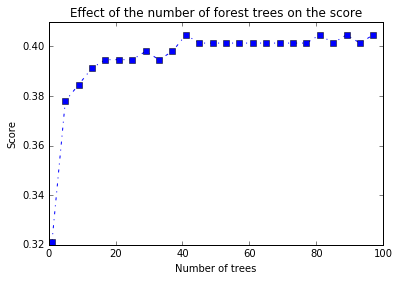

In [29]:
# Plot the score (on the validation data) as a function of Number of trees
treeNum = np.arange(1, 100, 4)
l1,= plt.plot(treeNum, np.vectorize(scoreFromNumEstim)(n_estimators=treeNum),'bs-.')
plt.xlabel('Number of trees')
plt.ylabel('Score')
plt.title('Effect of the number of forest trees on the score')
plt.show()

**Observation:** We can see from this plot that the score increase linearly with the number of trees until reaching a local maximum (~20 trees). For the number of trees above this local maximum, the score will vary around 40% with a global maximum at ~72 trees.

**Conclusion:** The bigger the number of trees is the better performance the model can achieve (especially if the number of trees is relatively small). In fact, the more trees the more **variance** reduction through the ensemble aggregate. However, as seen in this plot, as the number of trees become very large, the performance is not improved that much and there is a tradeoff between complexity and performance.

### b. Max depth:

We will plot the score (on the validation data) as a function of the max depth of the tree.All the other parameters are unchanged:

In [30]:
def scoreFromMaxDepth (max_depth):
    obs=[]
    for i in range(1,100):
        obs.append(RandomForestClassifier(n_estimators=20,max_depth=max_depth).fit(X_train, Y_train).score(X_valid,Y_valid))
    return np.median(obs)

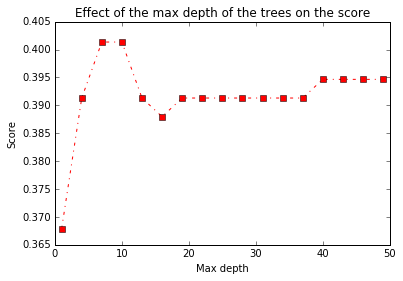

In [31]:
maxDepth = np.arange(1, 50, 3)
l1,= plt.plot(maxDepth, np.vectorize(scoreFromMaxDepth)(max_depth=maxDepth),'rs-.')
plt.xlabel('Max depth')
plt.ylabel('Score')
plt.title('Effect of the max depth of the trees on the score')
plt.show()

**Observation:** We can see from this plot that the score increases with the maximal depth of the tree until reaching a global maximum (Max depth ~15). Then a slight decrease in performance is observed as max depth increases.

**Conclusion:** The performance increases when we increase the depth of the trees because depth reduce biais especially when the depth is relatively small which cause high biais leading to  poor performance(e.g. for a depth of 3 the performance is minimal). However, very large depth may cause overfitting: Hence reduce performance.

### c. Minimal number of samples per leaf:**

We will plot the score (on the validation data) as a function of the minimal sample leaf of the tree. All the other parameters are unchanged:

In [32]:
def scoreFromMinSamlpleLeaf (min_samples_leaf):
    obs=[]
    for i in range(1,100):
        obs.append(RandomForestClassifier(n_estimators=40,min_samples_leaf=min_samples_leaf).fit(X_train, Y_train).score(X_valid,Y_valid))
    return np.median(obs)

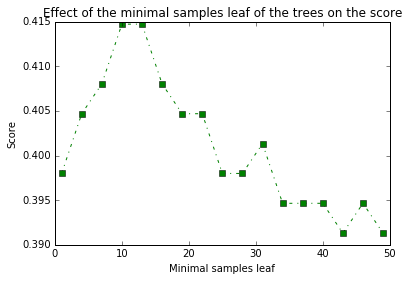

In [33]:
minSamplesLeafs = np.arange(1, 50, 3)
l1,= plt.plot(minSamplesLeafs, np.vectorize(scoreFromMinSamlpleLeaf)(min_samples_leaf=minSamplesLeafs),'gs-.')
plt.xlabel('Minimal samples leaf')
plt.ylabel('Score')
plt.title('Effect of the minimal samples leaf of the trees on the score')
plt.show()

**Observation:** We can see from this plot that the score is minimal when the minimal number of samples allowed per leaf is very small and when it is very large. In fact optimal scores corresponds to minimal samples leaf values around 10 samples.

**Conclusion:** A small number of samples per leaf means further splitting and hence deeper trees. So as we saw with Max_depth, althought deep trees decrease biais, they cause overfitting which is clear from the increasing part of the curve (increasing min samples/leaf increases performance). On the other hand, further increase of the min number of samples per leaf decreases performance. In fact, large number of samples per leaf means shorter trees and hence increase in the biais which decrease the performance. Hence, not surprising, the optimal value is not too smal nor too large.

### d. Minimal sample split:

We will plot the score (on the validation data) as a function of the minimal sample split of the tree. It means the minimum number of samples above which we can split further. All the other parameters are unchanged:

In [34]:
def scoreFromMinSamlpleSplit (min_samples_split):
    obs=[]
    for i in range(1,100):
        obs.append(RandomForestClassifier(n_estimators=40,min_samples_split=min_samples_split).fit(X_train, Y_train).score(X_valid,Y_valid))
    return np.median(obs)

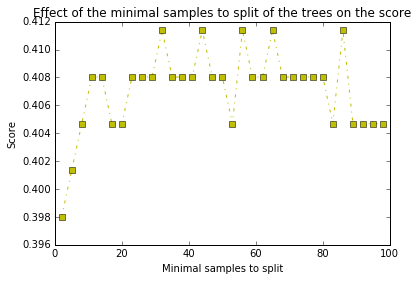

In [36]:
minSamplesSplit = np.arange(2, 100, 3)
l1,= plt.plot(minSamplesSplit, np.vectorize(scoreFromMinSamlpleSplit)(min_samples_split=minSamplesSplit),'ys-.')
plt.xlabel('Minimal samples to split')
plt.ylabel('Score')
plt.title('Effect of the minimal samples to split of the trees on the score')
plt.show()

**Observation:** Not surprisingly, we can see that the shape of this curve is similar to the minimal sample split curve. In fact, the minimal samples to split is twice to the number of samples per leaf. In other words, splitting when a node has at least 2n samples is equivalent to having a maximal number of samples per leaf of n samples. So the same observation and conclusion of the previous part hold.

### e. Max features:

We will plot the score (on the validation data) as a function of the max number of features to consider when looking for the best split.

In [37]:
def scoreFromMaxFeatures(max_features):
    obs=[]
    for i in range(1,50):
        obs.append(RandomForestClassifier(n_estimators=40,max_features=max_features).fit(X_train, Y_train).score(X_valid,Y_valid))
    return np.median(obs)

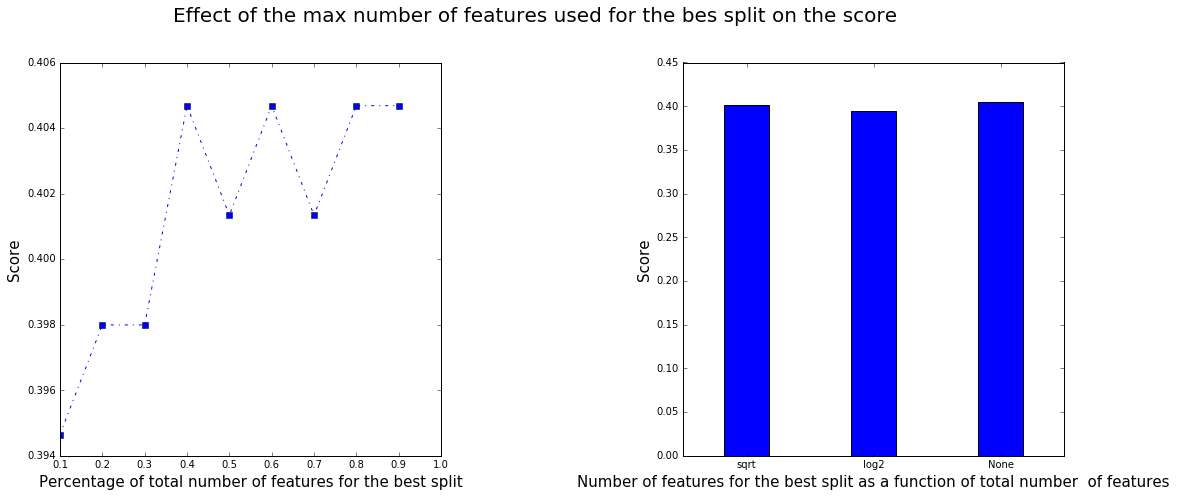

In [38]:
maxFeaturesCont = np.arange(0.1,1,0.1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
maxFeaturesFunc = ['sqrt','log2',None]
scores=np.vectorize(scoreFromMaxFeatures)(max_features=maxFeaturesFunc)
width = 0.35 
# Plot the score as a function of the number of features
axes[0].plot(maxFeaturesCont, np.vectorize(scoreFromMaxFeatures)(max_features=maxFeaturesCont),'bs-.')
axes[0].set_xlabel('Percentage of total number of features for the best split',fontsize=15)
axes[0].set_ylabel('Score',fontsize=15)

# Plot a bar chart for scores for pre-built functions
axes[1].bar(range(len(maxFeaturesFunc)), scores, width,align='center')
axes[1].set_xlabel('Number of features for the best split as a function of total number  of features',fontsize=15)
axes[1].set_ylabel('Score',fontsize=15)
plt.sca(axes[1])
plt.xticks(range(len(maxFeaturesFunc )), maxFeaturesFunc, size="medium")

# Translate subplots for better visiualisation
pos = axes[1].get_position()
axes[1].set_position(pos.translated(tx =-0.1,ty=0.1))
fig.suptitle('Effect of the max number of features used for the bes split on the score', fontsize=20)
fig.tight_layout()


**Observation:** Both graphs agree on the fact that the more number of fetures you pick for the best split, the better the performance is. This is shown on the first graph by the increasing aspect of the curve and on the second graph by an optimal score for the 'None' argument (note that None means fetures selected= all features).

**Conclusion:** Normally a big number of features is more likely to causes an overfitting problem because at each split all features will be taken into account. In our case a big number of features does not seem to cause overfitting maybe because of the big difference of importance among features.

## 3. Cross-validation & Overfitting:

In [39]:
X.head(2)

,defeats,games,weight,club,redCards,yellowReds,height,birthday,leagueCountry,position,goals,ties,yellowCards,victories
player,,,,,,,,,,,,,,
Adriano,84,369,67.0,28,3,1,172.0,918,3,7,32,59,57,226
Adrián Colunga,82,178,69.0,34,0,1,171.0,606,3,2,39,43,22,53


In [42]:
Y

array([1, 1, 1, ..., 1, 0, 0])

In [ ]:
clf=RandomForestClassifier(n_estimators=40)
scores = cross_val_score(clf, X, Y)